# Causal Inference in Decision Intelligence – Part 13: Choosing the Right Causal Effect

Link to the article:  [Choosing the Right Causal Effect](https://www.linkedin.com/pulse/causal-inference-decision-intelligence-part-13-right-effect-zinoviev-in4lc)

In [ ]:
# Check if dowhy is installed, and install it if not
try:
    import dowhy
except ImportError:
    import subprocess
    import sys
    print("Installing dowhy...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "dowhy"])
    import dowhy

In [5]:
# Import libraries
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx
from dowhy import CausalModel

import warnings
warnings.filterwarnings('ignore')

import dowhy.gcm as gcm

## ATT versus ATU

In [6]:
# Generate the data for an intuitive example

np.random.seed(3)

# Generate customers' Ids 
df = pd.DataFrame({'Id': range(1,11)})

# Generate Income variable 
df['Loyalty'] = np.where(df.Id>6, 1, 0)
df['Income'] = np.where((df.Id<4) | (df.Id==7), 0, 1)

# Generate sales
df['Sales'] = 10 + 2 * df.Income + 3 * df.Loyalty + 4 * df.Loyalty * df.Income

In [7]:
df

,Id,Loyalty,Income,Sales
0,1,0,0,10
1,2,0,0,10
2,3,0,0,10
3,4,0,1,12
4,5,0,1,12
5,6,0,1,12
6,7,1,0,13
7,8,1,1,19
8,9,1,1,19
9,10,1,1,19


In [8]:
# Estimate the effects with linear regression
model_att = smf.ols('Sales ~ Loyalty*Income', df).fit().summary().tables[1]
model_att

C:\Users\yevge\anaconda3\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  res = hypotest_fun_out(*samples, **kwds)


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,10.0000,5.35e-15,1.87e+15,0.000,10.000,10.000
Loyalty,3.0000,1.07e-14,2.81e+14,0.000,3.000,3.000
Income,2.0000,7.56e-15,2.65e+14,0.000,2.000,2.000
Loyalty:Income,4.0000,1.31e-14,3.05e+14,0.000,4.000,4.000


## Total, Direct and Indirect effects


In [9]:

np.random.seed(3)

# Generate customers' Ids 
Id = pd.Series(range(1,1001))

# Generate Income variable 
#Income = np.random.choice(["Low", "Medium", "High"], size=1000, p=[0.5, 0.35, 0.15])
Income = np.random.choice([1, 2, 3], size=1000, p=[0.5, 0.35, 0.15])


data = pd.DataFrame({"Id": Id, "Income": Income})

# Generate dates 
Year = pd.Series(range(2020,2024))

# Create the product of Ids and Years
year = pd.DataFrame({'Year': Year})
data = year.merge(data, how='cross')

# Generate Macro variable 
data["Macro"] = np.where(((data.Year==2022) | (data.Year==2020)), 1, 0)

# Create Price variable 
data['Price'] = 10 + 2 * data.Macro + np.random.normal(loc=0, scale=0.5, size=4000) 

# Create other variables 
data['Loyalty'] = 80 - 10 * data.Macro + np.random.normal(loc=2, scale=1, size=4000) 
data['Visits'] = 0.1 * data.Loyalty + np.random.normal(loc=0, scale=0.5, size=4000) 

data['Sales'] = 80 + 28 * data.Macro + 14 * data.Income - 7 * data.Price + 4 * data.Visits + 0.5 * data.Loyalty + np.random.normal(loc=0, scale=5, size=4000)

data.sample(20)


,Year,Id,Income,Macro,Price,Loyalty,Visits,Sales
51,2020,52,1,1,11.592328,71.577206,7.032273,106.393591
3582,2023,583,1,0,10.382522,83.363589,8.430654,100.989987
1130,2021,131,1,0,10.373959,83.608966,8.147304,96.889844
2927,2022,928,1,1,11.175317,73.532787,7.125739,106.090393
23,2020,24,1,1,11.020734,71.208528,7.699894,108.854847
3444,2023,445,3,0,10.199208,81.610936,8.890104,122.724296
1250,2021,251,3,0,10.080402,81.157260,8.391234,131.505148
2410,2022,411,3,1,12.040938,73.520657,7.711044,141.796487
1451,2021,452,1,0,9.687792,80.856476,8.187418,102.330257
1148,2021,149,2,0,9.959539,81.986081,7.272279,110.450705


In [10]:
# Create the true DAG
G = nx.DiGraph([('Macro', 'Sales'), ('Macro', 'Price'), ('Macro', 'Loyalty'), 
                ('Income', 'Sales'), ('Price', 'Sales'), ('Loyalty', 'Visits'), 
                ('Visits', 'Sales'), ('Loyalty', 'Sales')])

# Create the list of labels for the DAG
labels = {0: 'Macro', 1: 'Sales', 2: 'Price', 3: 'Loyalty', 4:'Income', 5: 'Visits'}

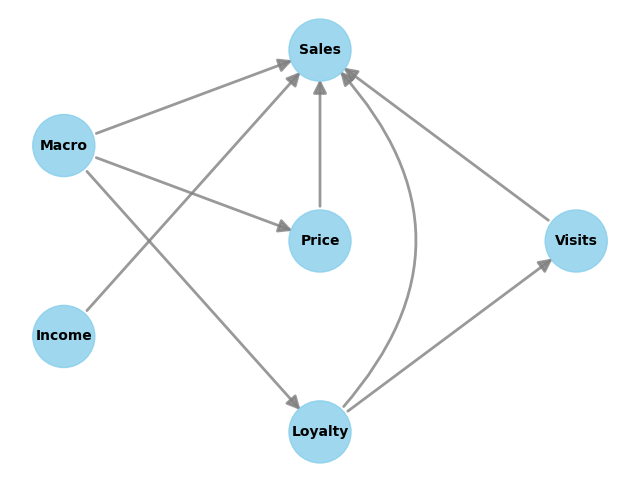

In [11]:
model = CausalModel(data=data,
                     graph=G,
                     treatment="Marketing",
                     outcome="Sales")
model.view_model()

In [12]:
# Calculate "Historical" effect
model_hist = smf.ols('Sales ~ Loyalty', data).fit().summary().tables[1]
model_hist

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,142.4105,2.920,48.778,0.000,136.687,148.134
Loyalty,-0.4258,0.038,-11.254,0.000,-0.500,-0.352


In [13]:
# Calculate "Historical" effect with the covariates
model_hist = smf.ols('Sales ~ Loyalty + Price + Income', data).fit().summary().tables[1]
model_hist

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,253.2164,4.808,52.665,0.000,243.790,262.643
Loyalty,-1.4340,0.039,-36.816,0.000,-1.510,-1.358
Price,-5.1901,0.178,-29.187,0.000,-5.539,-4.841
Income,14.3481,0.132,108.904,0.000,14.090,14.606


In [ ]:
The historical effects have the opposite direction: an increase in Loyalty decreases Sales.  

In [14]:
# Calculate "Total" effect
model_total = smf.ols('Sales ~ Loyalty + Price + Income + Macro', data).fit().summary().tables[1]
model_total

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,82.5151,7.237,11.403,0.000,68.327,96.703
Loyalty,0.8686,0.086,10.151,0.000,0.701,1.036
Price,-7.0430,0.173,-40.736,0.000,-7.382,-6.704
Income,14.2884,0.119,119.679,0.000,14.054,14.522
Macro,27.6797,0.937,29.541,0.000,25.843,29.517


In [16]:
# Calculate "Direct" effect
model_direct = smf.ols('Sales ~ Loyalty + Income + Price + Macro + Visits', data).fit().summary().tables[1]
model_direct

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,84.8035,6.718,12.624,0.000,71.633,97.974
Loyalty,0.4285,0.081,5.271,0.000,0.269,0.588
Income,14.2175,0.111,128.252,0.000,14.000,14.435
Price,-7.0228,0.160,-43.759,0.000,-7.337,-6.708
Macro,27.4034,0.870,31.505,0.000,25.698,29.109
Visits,4.1116,0.162,25.351,0.000,3.794,4.430


In [17]:
# Estimate the effect of variables on Visits
model_direct = smf.ols('Visits ~ Loyalty + Income + Price + Macro', data).fit().summary().tables[1]
model_direct

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-0.5566,0.655,-0.849,0.396,-1.841,0.728
Loyalty,0.1070,0.008,13.815,0.000,0.092,0.122
Income,0.0172,0.011,1.594,0.111,-0.004,0.038
Price,-0.0049,0.016,-0.313,0.754,-0.036,0.026
Macro,0.0672,0.085,0.792,0.428,-0.099,0.234


###### Calculate "Indirect" effect

Approach 1

Indirect = Total - Direct = 0.8686 - 0.4285 = 0.4401
 
Approach 2

Indirect = Loyalty_Visits * Visits_Sales = 0.107 * 4.1116 = 0.4399

In [15]:
# Calculate "Total" effect with interactions
model_total = smf.ols('Sales ~ (Loyalty + Price) * Income + Macro', data).fit().summary().tables[1]
model_total

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,95.6342,12.421,7.699,0.000,71.282,119.987
Loyalty,0.7784,0.119,6.566,0.000,0.546,1.011
Price,-7.6053,0.409,-18.593,0.000,-8.407,-6.803
Income,6.3927,6.114,1.046,0.296,-5.593,18.379
Loyalty:Income,0.0538,0.050,1.087,0.277,-0.043,0.151
Price:Income,0.3419,0.226,1.513,0.130,-0.101,0.785
Macro,27.6566,0.937,29.515,0.000,25.819,29.494
